# Exercise 1 - Face Recognition

Leveraging facial images sourced from the Yale B Database, encompassing a collection of 10 distinct faces captured across 64 diverse lighting scenarios, we employed the Eigenfaces technique. This approach combines Principal Component Analysis (PCA) for effective component extraction and a nearest neighbour classifier to achieve facial recognition. Our objective was to assess the method's ability in identifying images characterized by lighting conditions differing from those on which the model was trained.

Importing the necesssary libraries

In [ ]:
import os
import random

import numpy as np
import cv2

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In case the faces folder is zipped

In [ ]:
# !unzip faces.zip

## Question I

We define a function that loads all the images of a specific set into an array, with each image converted to a flattened array of numbers. Standardization (by subtracting the mean value and dividing with the standard deviation) is also performed across the set. An approach where the standardization was applied only to the images of the same person was implemented, but the results were much worse.

In [ ]:
sets = [[1,7], [8,19], [20,31], [32,45], [46,64]]

def standardize(vector):
  scaler = StandardScaler()
  transformed = scaler.fit_transform(vector)
  return scaler, transformed

def loadImages(path, set_number):
  set_number -= 1

  files = []
  array = []
  labels = []

  for file_name in os.scandir(path):
    file_name = file_name.name
    file_end = int(file_name.split("_")[1].split(".png")[0])
    if file_end >= sets[set_number][0] and file_end <= sets[set_number][1]:
      files.append(file_name)

      img = cv2.imread(os.path.join(path, file_name), 0)
      arr = np.array(img)
      flat_arr = arr.ravel()

      array.append(flat_arr)
      labels.append(int(file_name.split("_")[0][6:]))

  scaler, array = standardize(array)

  return array, labels, scaler


vectors = []
labels = []
scalers = []
for i in range(1,6):
  result = loadImages("faces", i)
  vectors.append(result[0])
  labels.append(result[1])
  scalers.append(result[2])

## Question II

Custom functions for PCA calculation with respect to one training set and score calculation for each set separately.

In [ ]:
def pca(n_components, x_train, vectors):
  pca = PCA(n_components=n_components)
  pca.fit(x_train)
  return pca, [pca.transform(x) for x in vectors]

def score(classifier, vectors, labels):
  for i, (x, y) in enumerate(zip(vectors, labels)):
    print("Set "+str(i)+": "+str(classifier.score(x,y)))

We notice that for 9 dimensions the PCA algorithm has 100% accuracy for Set 1, as expected, because of it being the training set. The algorithm can also generalize well for sets 2 and 3, but not for sets 4 and 5, probably due to the much different lighting conditions of those sets, compared to the first one.

In [ ]:
pca9, x9 = pca(9, vectors[0], vectors)
classifier_knn = KNeighborsClassifier(n_neighbors=1)
classifier_knn.fit(x9[0], labels[0])
score(classifier_knn, x9, labels)

Set 0: 1.0
Set 1: 0.9166666666666666
Set 2: 0.725
Set 3: 0.3
Set 4: 0.18421052631578946


When we increase the dimensions to 30, the algorithm still has 100% accuracy for Set 1, as expected, but also has a stronger ability of generalization across all sets. However, results on sets 4 and 5 are still not decent, while results for sets 2 and 3 are very accurate.

In [ ]:
pca30, x30 = pca(30, vectors[0], vectors)
classifier_knn = KNeighborsClassifier(n_neighbors=1)
classifier_knn.fit(x30[0], labels[0])
score(classifier_knn, x30, labels)

Set 0: 1.0
Set 1: 0.9666666666666667
Set 2: 0.8583333333333333
Set 3: 0.42857142857142855
Set 4: 0.21052631578947367


## Question III

We plot the 9 top eigenvectors that have been produced after training on Set 1. Each eigenvector depicts a feature such as the mouth, the nose, the eyebrows or the lighting of the picture.

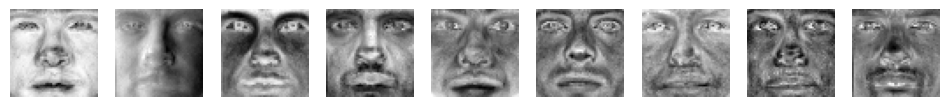

In [ ]:
def plot_pca_eigenvectors(pca):
  fig = plt.figure(figsize=(12, 6))
  for i in range(pca.n_components):
    ax = fig.add_subplot(1, 9, i+1)
    ax.imshow(pca.components_[i].reshape((50,50)), cmap='gray')
    plt.axis('off')

plot_pca_eigenvectors(pca9)

## Question IV

When reconstructing a picture frome each set, it is evident that using more components (30 vs 9) produces more accurate results, as more components retain more information of the actual picture. It is also evident that pictures from the first 3 sets are better reconstructed than those of the last 2 sets, which is due to the methods being trained with data from the first set, the lighting of which is closer the lighting of sets 2 and 3. This is actually a representation of the scores observed in Question II, where we saw that the PCA trained on Set 1 only scored decently on sets 2 and 3.

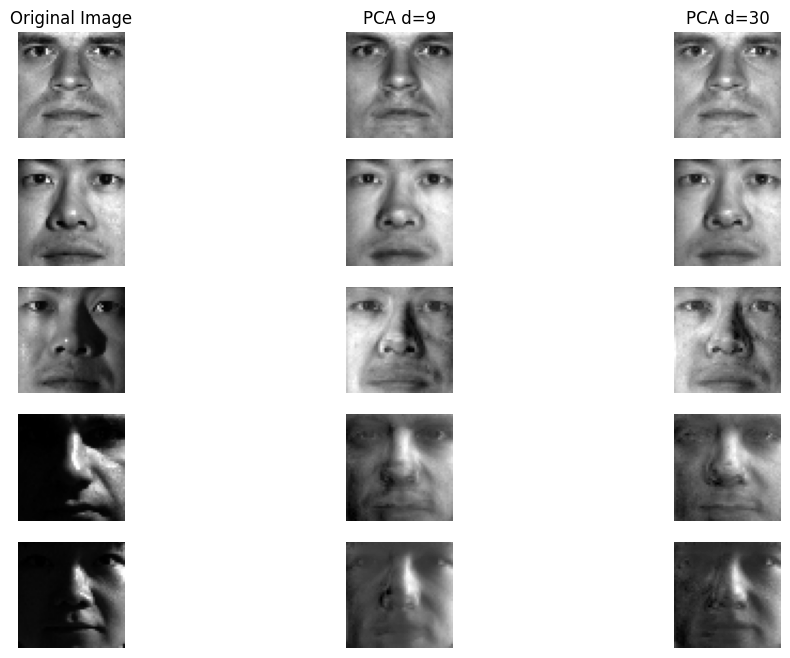

In [ ]:
fig = plt.figure(figsize=(12, 8))

for i in range(5):

  inversed_original = scalers[i].inverse_transform(vectors[i])
  pca_inversed_x9 = pca9.inverse_transform(x9[i])
  inversed_x9 = scalers[i].inverse_transform(pca_inversed_x9)
  pca_inversed_x30 = pca30.inverse_transform(x30[i])
  inversed_x30 = scalers[i].inverse_transform(pca_inversed_x30)

  index = random.randint(0, len(vectors[i]))

  ax1 = fig.add_subplot(5, 3, 3*i+1)
  ax1.imshow(inversed_original[index].reshape((50,50)), cmap='gray')

  ax2 = fig.add_subplot(5, 3, 3*i+2)
  ax2.imshow(inversed_x9[index].reshape((50,50)), cmap='gray')

  ax3 = fig.add_subplot(5, 3, 3*i+3)
  ax3.imshow(inversed_x30[index].reshape((50,50)), cmap='gray')

  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')

  if i == 0:
    ax1.title.set_text('Original Image')
    ax2.title.set_text('PCA d=9')
    ax3.title.set_text('PCA d=30')

## Question V

The 9 most important singular vectors produced after performing Singular value decomposition (SVD) on Set 1 are plotted in the first row of the image below. The 9 most important eigenvectors of PCA are plotted in the second row of the same image.
As we can see, the prominent features of SVD and PCA are very similar, with only the lighting changing in some areas (darker areas in SVD are lighter in PCA and vice versa).<br>

This is because PCA is a technique that uses SVD in order to perform dimensionality reduction.
* SVD decomposes a matrix into three components: U, Σ, and V^T.
* PCA uses SVD to decompose the covariance matrix of the data into principal components.
* The principal components, represented by the columns of U, capture the directions of maximum variance in the data.
* PCA leverages SVD to perform dimensionality reduction by selecting a subset of principal components (columns of U) that explain most of the variance, thereby reducing the dimensionality of the data.

Summarizing, PCA uses SVD to decompose the covariance matrix of the data into principal components. Those principal components represent the directions of maximum variance, and by selecting a subset of them, we can achieve dimensionality reduction with PCA. Thus, the results of PCA (the eigenvectors) are very similar to the results of SVD (the singular vectors).

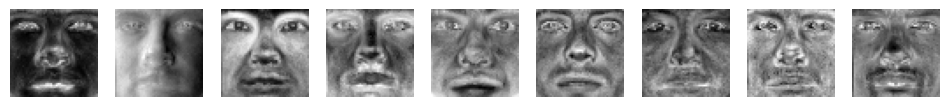

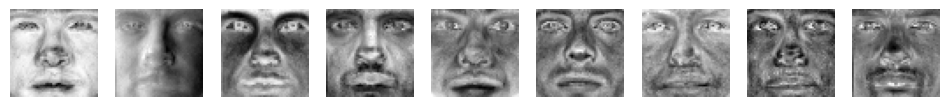

In [ ]:
_, _, vh = np.linalg.svd(vectors[0])

def plot_svd_eigenvectors(n_components, vector):
  fig = plt.figure(figsize=(12, 6))
  for i in range(n_components):
    ax = fig.add_subplot(1, 9, i+1)
    ax.imshow(vector[i].reshape((50,50)), cmap='gray')
    plt.axis('off')

plot_svd_eigenvectors(9, vh)
plot_pca_eigenvectors(pca9)

# Exercise 2 - Handwritten Digits Recognition

We employ Support Vector Machines (SVMs) for the classification of images depicting handwritten digits sourced from the MNIST dataset.

Importing the necessay libraries

In [ ]:
from keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import time

We load the MNIST data for training and testing purposes.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

We transform each 28x28 image into a flattened 1x784 array.

In [ ]:
x_train = [i.squeeze().flatten() for i in x_train]
x_test = [i.squeeze().flatten() for i in x_test]

We also normalize the data between 0 and 1.

In [ ]:
scaler = MinMaxScaler()

scaler.fit(x_train)
x_train_norm = scaler.transform(x_train)
x_test_norm = scaler.transform(x_test)

For tuning the hyperparameters of SVM we use the `GridSearchCV()` function which performs an exhaustive search over specified parameter values. By exeperimentation it was found that SVM performed well for values of C near 1 and values of gamma near `1 / (n_features * X.var())`, which is also the default option of the sklearn library. This value for our training data is close to 0.0000001, so we choose options close to this number. The kernel of the SVM can be linear or rbf, according to the instructions.

Default value of k in the cross-validation performed during GridSearchCV is 5, so 20% of the training data were used for the validation after each fit.

In [ ]:
param_grid = {'C': [0.1, 1, 10],
              'gamma': [0.000001, 0.0000001, 0.00000001],
              'kernel': ['linear', 'rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, n_jobs=8)

# fitting the model for grid search
grid.fit(x_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 3/5] END .C=0.1, gamma=1e-06, kernel=linear;, score=0.896 total time= 1.1min
[CV 2/5] END .C=0.1, gamma=1e-06, kernel=linear;, score=0.909 total time= 1.1min
[CV 5/5] END .C=0.1, gamma=1e-06, kernel=linear;, score=0.906 total time= 1.2min
[CV 4/5] END .C=0.1, gamma=1e-06, kernel=linear;, score=0.912 total time= 1.2min
[CV 1/5] END .C=0.1, gamma=1e-06, kernel=linear;, score=0.915 total time= 1.2min
[CV 3/5] END .C=0.1, gamma=1e-07, kernel=linear;, score=0.896 total time= 1.1min
[CV 2/5] END .C=0.1, gamma=1e-07, kernel=linear;, score=0.909 total time= 1.2min
[CV 1/5] END .C=0.1, gamma=1e-07, kernel=linear;, score=0.915 total time= 1.2min
[CV 4/5] END .C=0.1, gamma=1e-07, kernel=linear;, score=0.912 total time= 1.2min
[CV 5/5] END .C=0.1, gamma=1e-07, kernel=linear;, score=0.906 total time= 1.2min
[CV 1/5] END ....C=0.1, gamma=1e-07, kernel=rbf;, score=0.939 total time= 3.8min
[CV 2/5] END ....C=0.1, gamma=1e-07, kernel=rbf;

GridSearchCV(estimator=SVC(), n_jobs=8,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1e-06, 1e-07, 1e-08],
                         'kernel': ['linear', 'rbf']},
             verbose=3)

After performing GridSearch it was found that the best hyperparameters for our problem are C=10, gamma=1e-07 and an rbf kernel, for which the score of across the 5 folds was close to 97% as seen from the output of the above cell.

In [ ]:
# print best parameter after tuning
print("The best hyperparameters found are:", grid.best_params_)

The best hyperparameters found are: {'C': 10, 'gamma': 1e-07, 'kernel': 'rbf'}


We also evaluate the above solution with the best found parameters on the testing set. We observe an excellent f1-score of 98%.

In [ ]:
grid_predictions = grid.predict(x_test)

# print classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



We can also perform PCA (Principal Component Analysis) and run the models again, in order to observe how many dimensions can be reduced without a significant performance loss.

For this purpose, thresholds of 0.8, 0.6 and 0.4 variance are selected. After running PCA for those values, it is observed that 0.803, 0.607 and 0.408 of the initial variance is retained repectively. This is achieved when using 44, 17 and 7 components respectively, thus reducing the dimensions of the problem to a very small number.

The best estimator according the previously chosen hyperparameters is fitted again for the new vectors with reduced dimensions and it is observed that with 44 components f1-score is kept in 98%, while with only 17 components f1-score still remains very high, close to 97%. However, when reducing the dimensions further and using only 7 components, f1-score is also reduced to 88%, still high, but with a significant loss from the initial 98%.

Thus, we can keep about 17 components without significantly reducing the performance of the model. This is a very good optimization from the initial dimension of 784 for each element, while accuracy is kept excessively high. This is an excellent trade-off between performance, dimensions and training time, since performance remained close to 97%, dimensions were reduced to only 17 and training time was reduced from about 1 minute to less than 6 seconds.

In [ ]:
for variance in [0.8, 0.6, 0.4]:

  print("---- Variance =", variance, "----")

  pca = PCA(n_components=variance)
  pca.fit(x_train)
  x_train_new = pca.transform(x_train)
  x_test_new = pca.transform(x_test)
  print(x_train_new.shape)

  print("Variance retained =", pca.explained_variance_ratio_.cumsum()[-1])
  print("Number of components =", len(pca.components_))

  clf = grid.best_estimator_
  t0 = time.time()
  clf.fit(x_train_new, y_train)
  t1 = time.time()
  y_pred = clf.predict(x_test_new)

  print(classification_report(y_test, y_pred))

  print("time", round(t1-t0,1), "s\n")

---- Variance = 0.8 ----
(60000, 44)
Variance retained = 0.8032907553836801
Number of components = 44
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.97      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

time 7.2 s

---- Variance = 0.6 ----
(60000, 17)
Variance retained = 0.6074124552802462
Number of components = 17
              precision  